# Training a predictive ML model


#### This notebook develops and tests ML models for prediction of song loudness from all the other given information within the "song_popularity" dataset. We observed that song loudness is correlated with "acousticness", "danceability", "energy" and "instrumentalness" levels of that song. To solve this problem, I am using tensorflow for training my neural network. The other option was pytorch. From my initial search, I learned that tensorflow has an API named keras that makes defining the neural network architecture easier.


 ##### I learned about Keras sequential and functional API in this link: https://www.analyticsvidhya.com/blog/2021/11/training-neural-network-with-keras-and-basics-of-deep-learning/
 ##### I deccided to use functional API

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


## Load the dataset

In [2]:
# Read data from csv
df = pd.read_csv('./song_data.csv')

## Define dependent and independent variables (X and Y)

In [3]:
# Removing the non-numeric column
df = df.drop('song_name', axis = 1) # axis = 1 is for columns - In the "data exploration" notebook I used dt_types() method to select only numeric columns, 
                                    # here I am using drop to filter the specific column
y = df['loudness']           # y is the target or dependent variable which is a single column
x = df.loc[:, ~(df.columns == 'loudness')] # The rest of the features are variables used to predict the target

## Create test and train dataset

In [4]:
# The "train_test_split" method in sklearn splits the entire dataset to test and train dataset in a random way
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size=0.33, random_state=42) # the random_state parameter sets the seed in sequence generation when the splitting is defined. 
                                            # for instance, I noticed 42 is commonly used. This specifies the initiation point. This makes the 
                                            # created splits to be reproducible


## Data processing

In [5]:
# This problem has 13 variables and the "DataExploration" notebook showed that they are significantly different in their values
# distribution, min and max(ranges). To train a neural network, we'd like to make them all consistent. We can either standardize or normalize
# them. I standardized the features, meaning that they have mean of 0 and standard deviation of 1.

# Data standardization (mean of 0 and standard deviation of 1) - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler() # object scaler is created from class StandardScaler()
# Fit the scaler on the training data and transform it
X_train_s = scaler.fit_transform(X_train)
# Use the same scaler to transform the testing data
X_test_s = scaler.transform(X_test)

### both the test and training set X values are transformed

## Build the layers of your Neural Network

In [6]:
# This step is highly experimental for me, since the definition of number of layers and their sizes are very important
# starting with an input layer:

## !!!!! I got the warning message that instead of keras.Input I have to use: tf.compat.v1.keras.Input. The code still runs but you will see an warning message
input_layer = keras.Input(shape=(X_train_s.shape[1],))  # I used this resource to use Keras core layers: https://keras.io/api/layers/core_layers/
                                                      # one of the parameters is shape that detemrines the size of the input. In this dataset we have
                                                      # 13 numeric columns, the second value of the shape attribute of the training dataset will give that value
                                                      # This has to be a tuple shape = (13,) indicates a vector with 13 entries

In [7]:
## Next, we should stack "Dense" layers to define the "hidden layers". there is the option to either incorporate activation function in the dense 
# layer or add an activation layer after Dense layer. I decided to use the activation functions available through keras.dense layer

# the first provided integer is the number of neurons or units within each hidden layer. 
hidden_layer = keras.layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.08))(input_layer) # we always have to pass the previous layer to the new layer
hidden_layer = keras.layers.Dense(32, activation  = 'relu', kernel_regularizer=regularizers.l2(0.08))(hidden_layer)

# I noticed from my loss vs epoch plot that my NN tends to overfit (ascending  validation loss and descending training loss). There is a parameter
# in the layers.Dense() called kernel_regulizer. We can give values between 0 and 1, which controls the strength of regularization.
# regularization penalizes the learned weights and prevents the model to lean the training data too well such that it is not generalizable to the
# test data

# My choice of activation function was arbitrary. I tested a few other option like sigmoid and it did not seem to improve the results


In [8]:
## then We have to define the output layer
output_layer = keras.layers.Dense(1)(hidden_layer) # the size of our output is "1" - level of loudness

## Creating the model

In [9]:
# creating the model:https://keras.io/api/models/model/
model = keras.Model(inputs = input_layer, outputs = output_layer) # creating a model with the defined input and output layers above

# summarizing the created architecture and model:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3009 (11.75 KB)
Trainable params: 3009 (11.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training and evaluation of the model


In [10]:
# Two methods should be used in a sequence, model.compile and model.fit. with model.compilte we specify what are the parameters in the learning process. 
# In other words, what type of loss function I'd like to use: there are about 14 different loss functions for a regression case. I started with the default ones
# I used this guide: https://keras.io/api/models/model_training_apis/
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model: the epochs and batch_size values were determined by trial and error.
# epochs represents the number of times the entire training data has been fed to the neural network and the batch_size represents the size of the subset
# of the training data that are fed to the model
result = model.fit(X_train_s, Y_train, epochs = 120, batch_size = 50, validation_split = 0.33, verbose = 2) # I have selected 33% of the testing data to be used for validation, this is different than the test set


Epoch 1/120

170/170 - 2s - loss: 22.9628 - val_loss: 11.0661 - 2s/epoch - 12ms/step
Epoch 2/120
170/170 - 0s - loss: 9.8014 - val_loss: 8.9153 - 455ms/epoch - 3ms/step
Epoch 3/120
170/170 - 0s - loss: 8.1952 - val_loss: 7.7958 - 447ms/epoch - 3ms/step
Epoch 4/120
170/170 - 0s - loss: 7.2683 - val_loss: 7.1041 - 449ms/epoch - 3ms/step
Epoch 5/120
170/170 - 0s - loss: 6.6773 - val_loss: 6.5615 - 448ms/epoch - 3ms/step
Epoch 6/120
170/170 - 0s - loss: 6.2213 - val_loss: 6.2774 - 448ms/epoch - 3ms/step
Epoch 7/120
170/170 - 0s - loss: 5.9243 - val_loss: 5.9732 - 452ms/epoch - 3ms/step
Epoch 8/120
170/170 - 0s - loss: 5.7232 - val_loss: 5.8219 - 497ms/epoch - 3ms/step
Epoch 9/120
170/170 - 0s - loss: 5.5478 - val_loss: 5.5965 - 438ms/epoch - 3ms/step
Epoch 10/120
170/170 - 0s - loss: 5.4044 - val_loss: 5.4765 - 436ms/epoch - 3ms/step
Epoch 11/120
170/170 - 0s - loss: 5.2796 - val_loss: 5.4064 - 439ms/epoch - 3ms/step
Epoch 12/120
170/170 - 0s - loss: 5.2370 - val_loss: 5.3561 - 443ms/epoc

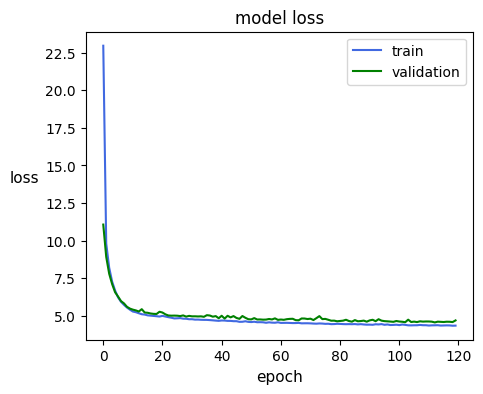

In [11]:
# summarize history for loss. I used this plot as a reference to learn if the model is over or under fitting. 
# The validation loss is still higher than the training one, which is expected but also shows that there is room for improvement
plt.figure(figsize = (5,4))
plt.plot(result.history['loss'], color = 'royalblue')
plt.plot(result.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss', rotation = 0, fontsize = 11, ha = 'right')
plt.xlabel('epoch', fontsize = 11)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluation of model performance

In [12]:
# The output of model.evaluate is the average of loss over the entire test set. since we specified in model.compile to have mse
# as the loss, there the output here is mean squared error of predictions
mse_NN = model.evaluate(X_test_s, Y_test) 
# I would like to compare the predictions made by the model against the actual values
predictions_NN = model.predict(X_test_s)

195/195 [==============================] - 0s 1ms/step


## Comparison of Neural Network versus Linear Regression predictions

In [13]:
# Train the linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_s, Y_train)

# Make predictions on the test set
predictions_reg = linear_reg_model.predict(X_test_s)
# Calculate Mean Squared Error
mse_reg = mean_squared_error(Y_test, predictions_reg) # https://www.machinelearningnuggets.com/python-linear-regression/


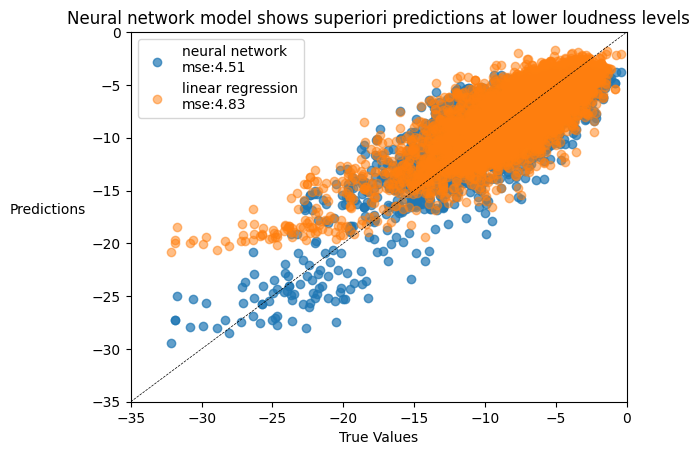

In [14]:
# Visualization of the goodness of the model fit for the two NN and LR models
plt.figure()
plt.scatter(Y_test, predictions_NN, alpha = 0.7)
plt.scatter(Y_test, predictions_reg, alpha = 0.5)
plt.plot(np.arange(-35,0,0.1), np.arange(-35,0,0.1), linestyle = '--', color = 'black', linewidth = 0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions', rotation = 0, ha = 'right')
plt.title('Neural network model shows superiori predictions at lower loudness levels')
# Set the range of the x-axis and y-axis to be the same
plt.xlim(-35, 0)
plt.ylim(-35,0)
plt.legend([f'neural network \nmse:{round(mse_NN,2)}',f'linear regression\nmse:{round(mse_reg,2)}'])
plt.show()